In [1]:
import pandas as pd
import numpy as np
import plotly
from matplotlib import pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot



import plotly.offline as offline
import plotly.graph_objs as go

# offline.init_notebook_mode()

print(plotly)

init_notebook_mode(connected=True)
# %matplotlib inline

<module 'plotly' from 'C:\\Anaconda3\\lib\\site-packages\\plotly\\__init__.py'>


In [2]:
Path = 'C:/FishIsland_2017/'#'FI_Data_Filled.csv'#_Filled.csv
df = pd.read_csv(Path,delimiter = ',',header = 0)
df = df.set_index(pd.DatetimeIndex(df.datetime))

Data = df.drop(df.columns[0],axis=1)


Data['Temp_2_Avg'] = (Data['Temp_2_5_1'] + Data['Temp_2_5_2'] + Data['Temp_2_5_3'])/3
Data['Temp_5_Avg'] = (Data['Temp_5_1'] + Data['Temp_5_2'] + Data['Temp_5_3'])/3
Data['Temp_15_Avg'] = (Data['Temp_15_1'] + Data['Temp_15_2'] + Data['Temp_15_3'])/3
Data['Active_Layer'] = (Data['Active_Layer_1']*.8 + Data['Active_Layer_2']*.2)*-100
Data['Canopy_Height'] = Data['Canopy_Height_1']*.8 + Data['Canopy_Height_2']*.2


bins = np.arange(Data['PPFD_Avg'].min(),Data['PPFD_Avg'].max(),(Data['PPFD_Avg'].max()-Data['PPFD_Avg'].min())/100)
Data['PhotonFlux'] = pd.cut(Data['PPFD_Avg'],bins=bins,labels = (bins[0:-1]+bins[1:])/2)
CO2 = Data.groupby(Data['PhotonFlux']).mean()
i = 0
Data['co2_norm'] = 0
for index,row in CO2.iterrows():
    Norm = Data['co2_flux_Filled'].loc[((Data['PPFD_Avg']< bins[i+1])&
                                                    (Data['PPFD_Avg']> bins[i]))]
#     print(Norm/row['co2_flux_Filled'])
    Data.loc[((Data['PPFD_Avg']< bins[i+1])&(Data['PPFD_Avg']> bins[i])),'co2_norm'] = Norm-row['co2_flux_Filled']
    
    i+=1
# print(Data['co2_norm'])

Daily = Data.groupby(Data.index.dayofyear).mean()
Daily = Daily.loc[((Daily.index>=174)&(Daily.index<=255))]
Daily_Std = Data.groupby(Data.index.dayofyear).std()
Daily_Max = Data.groupby(Data.index.dayofyear).max()
Daily_Min = Data.groupby(Data.index.dayofyear).min()
Daily[['PPFD','Rain']] = Data[['PPFD_Avg','Rain_mm_Tot']].groupby(Data.index.dayofyear).sum()
Daily['PPFD']/=1000

Hourly = Data.groupby(Data.index.hour).mean()

Daily['co2_Carbon'] = Daily['co2_flux_Filled']* 1e-6 * 12.0107 *3600*24
Daily['ch4_Carbon'] = Daily['ch4_flux_Filled']* 1e-6 * 12.0107 *3600*24

Daily['co2_flux_Filled'] = Daily['co2_flux_Filled']* 1e-6 * 44.0095 *3600*24
Daily['ch4_flux_Filled'] = Daily['ch4_flux_Filled']* 1e-3 * 16.04246 *3600*24

# print(Daily[['PPFD_Avg','co2_flux_Filled']])

In [3]:
from scipy.optimize import curve_fit
from scipy import stats
from sklearn import metrics
def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def R_2(Ta,R0,Q10):
    return(R0*np.exp(np.log(Q10)/10*Ta))
def P_func(PPFD,MQY,PM):
    cv =.7
    return(MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5/(2*cv))

## Fit the Curves
Dark_Thresh = 10
Dark = Data[Data['PPFD_Avg']<=Dark_Thresh]
Dark.loc[Dark['co2_flux']<0,'co2_flux']=np.nan
Dark = Dark[['co2_flux','PPFD_Avg','Temp_5_Avg','u*','Table_1','AirTC_Avg']].dropna()
popt_r, pcov = curve_fit(R_func, Dark['Temp_5_Avg'], Dark['co2_flux'],p0=(1,1,1))
Data['R'] = R_func(Data['Temp_5_Avg'],*popt_r)
Data['GPP'] = (Data['co2_flux']-Data['R'])*-1
P = Data[Data['PPFD_Avg']>=Dark_Thresh]
P = P[['GPP','PPFD_Avg']].dropna()
popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], P['GPP'],p0=(.003,12))

## Ordered Data for Plotting fits
Temp = np.arange(Data['Temp_5_Avg'].min(),Data['Temp_5_Avg'].max(),.25)
# ATemp = np.arange(Data['AirTC_Avg'].min(),Data['AirTC_Avg'].max(),.25)
PAR = np.arange(Data['PPFD_Avg'].min(),Data['PPFD_Avg'].max(),1)

Data['GPP_Calc'] = P_func(Data['PPFD_Avg'],*popt_p)
Data['NEEFill'] = -1*Data['GPP_Calc']+Data['R']
Data['NEEFilled'] = Data['co2_flux'].fillna(Data['NEEFill'])

# Daily = Daily[1:-1]    

Rsq_Resp = metrics.explained_variance_score(Dark['co2_flux'].values,R_func(Dark['Temp_5_Avg'],*popt_r))
Rsq_GPP = metrics.explained_variance_score(P['GPP'].values,P_func(P['PPFD_Avg'],*popt_p))

# print(Rsq_Resp,Rsq_GPP)

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



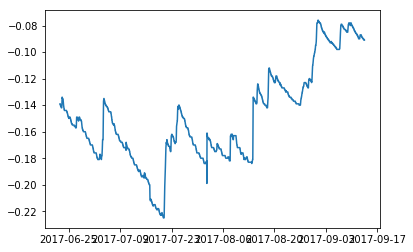

0.202244394619 0.51255353902
-0.225 -0.076 -0.1490779482021622


In [4]:

MTitle = 55
STitle = 44
AxTitle = 35
LFont = 32
Tik = 30
Mrk = 15
Mrk_small = 8
Lyn = 6
Wisk = 3
GW = 4
Gcolor = 'rgba(200,200,200,.8)'
Fcolor = 'rgba(20,20,20,1)'
BGCL = 'rgb(250,250,250)'
PLCL = 'rgb(250,250,250)'
plt.figure()
plt.plot(Data['Table_3'])
# plt.plot(Data['Active_Layer_2'])
plt.show()
print(Data['Active_Layer_2'].min(),Data['Active_Layer_1'].max())
print(Data['Table_3'].min(),Data['Table_3'].max(),Data['Table_3'].mean())


In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

CO2 = Daily['co2_flux_Filled'].cumsum()
CH4 = Daily['ch4_flux_Filled'].cumsum()*1e-3*28
Ballance = CO2+CH4
Carbon = Daily['co2_Carbon'].cumsum()+Daily['ch4_Carbon'].cumsum()

print(Daily['co2_Carbon'].mean()+Daily['ch4_Carbon'].mean())
print(Daily['ch4_flux_Filled'].mean()*1e-3*28+Daily['co2_flux_Filled'].mean())

Daily['co2_flux_Filled'].sum()

# print(CH4)

print(CO2[255])
print(CH4[255])
print(Ballance[255])
print(Carbon[255])

fig = tools.make_subplots(rows=1, cols=1)

trace1 = go.Scatter(y=CO2,x=Daily.index,line=dict(color='rgba(0,180,0,.8)',width=Lyn),
                   )
trace2 = go.Scatter(y=CH4,x=Daily.index,line=dict(color='rgba(180,0,0,.8)',width=Lyn),
                   )
trace3 = go.Scatter(y=Ballance,x=Daily.index,line=dict(color='rgba(150, 100, 75,1',width=Lyn),
                   )
trace4 = go.Scatter(y=Carbon,x=Daily.index,line=dict(color='rgba(0, 0, 0,1)',width=Lyn),
                   )

height = 1500
width = 2000


fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace3, 1, 1)
fig.append_trace(trace4, 1, 1)

# data=[trace1,trace2,trace3]

# layout = go.Layout(
#     height=height,
#     width=width

fig['layout'].update(
    width=width,
    height=height,
    autosize=False,
    margin=go.Margin(
        l=150,
        r=150,
        b=150,
        t=150,
        pad=25,
    ),paper_bgcolor=BGCL,plot_bgcolor=PLCL,
    title='Cumulative Carbon Balance',
    font=dict(
        size=MTitle,color=Fcolor
    ),showlegend=False,
#     legend=dict(x=.1,y=0)
)

fig['layout']['xaxis1'].update(title='Day of Year',
                               gridcolor=Gcolor,gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},
                               tickfont=dict(color=Fcolor,size=Tik),zerolinecolor=Gcolor,zerolinewidth=GW)
fig['layout']['yaxis1'].update(title='g m<sup>-2</sup>',
                               gridcolor=Gcolor,gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},
                               tickfont=dict(color=Fcolor,size=Tik),zerolinecolor=Gcolor,zerolinewidth=GW)
    
fig['layout']['annotations'].extend([dict(yref = 'y1',y = -67,
        xref= 'x1',x = 198,text = 'g CO<sub>2</sub>',showarrow=True,
        font = {'color':Fcolor,'size': AxTitle},xanchor = 'center',yanchor = 'top',
        arrowhead=5,ay=100,ax=-30
    ),dict(yref = 'y1',y = 71,
        xref= 'x1',x = 220,text = 'CH<sub>4</sub>: g CO<sub>2</sub> eq.',showarrow=True,
        font = {'color':Fcolor,'size': AxTitle},xanchor = 'right',yanchor = 'bottom',
        arrowhead=5,ay=-20,ax=-55,
    ),dict(yref = 'y1',y = -51,
        xref= 'x1',x = 222,text = 'g CO<sub>2</sub> eq.',showarrow=True,
        font = {'color':Fcolor,'size': AxTitle},xanchor = 'left',yanchor = 'top',
        arrowhead=5,ay=30,ax=40,
    ),dict(yref = 'y1',y = -25,
        xref= 'x1',x = 210,text = 'g C',showarrow=True,
        font = {'color':Fcolor,'size': AxTitle},xanchor = 'left',yanchor = 'bottom',
        arrowhead=5,ay=-30,ax=40,
         )])


offline.iplot(fig,filename = 'Cumulative',image='png',image_height=height,image_width = width)



-0.44357753230440855
-0.3954027062738421
-144.233632438
111.810610523
-32.4230219145
-36.373357649
This is the format of your plot grid:
[ (1,1) x1,y1 ]



In [11]:
import statsmodels.stats.api as sms



CO2 = Daily['co2_flux_Filled']
CH4 = Daily['ch4_flux_Filled']*1e-3*28
F = CO2+CH4

# print(F)
print(F.mean())
CI = sms.DescrStatsW(F).tconfint_mean()
print((CI[1]-CI[0])/2)


F = 'co2_flux_Filled'
trace1 = go.Bar(
        y=Daily[F],
        x=Daily.index,
        name = 'CO<sub>2</sub>: '+str(np.round(Daily[F].mean(),2)) + ' g m<sup>-2</sub> d<sup>-1</sub>',
        marker=dict(color='rgb(0, 180, 0)')
)

print(F)
print(Daily[F].mean())
CI = sms.DescrStatsW(Daily[F]).tconfint_mean()
print((CI[1]-CI[0])/2)

Daily['Mean']=str(np.round(Daily[F].mean(),1))
trace1_2 = go.Scatter(y=Daily['Mean'],x=Daily.index,
    line=dict(color = 'rgba(0, 0, 0, .8)',width=Lyn)
)
                      
        
    
    
F = 'ch4_flux_Filled'
trace2 = go.Bar(
        y=Daily[F],
        x=Daily.index,
        name = 'CH<sub>4</sub>: '+str(np.round(Daily[F].mean(),1)) + ' mg m<sup>-2</sub> d<sup>-1</sub>',
        marker=dict(color='rgb(180, 0, 0)')
    )

Daily['Mean2']=str(np.round(Daily[F].mean(),1))
trace2_2 = go.Scatter(y=Daily['Mean2'],x=Daily.index,
    line=dict(color = 'rgba(0, 0, 0, .8)',width=Lyn)
)


print(F)
print(Daily[F].mean())
CI = sms.DescrStatsW(Daily[F]).tconfint_mean()
print((CI[1]-CI[0])/2)



SubTitles = ['Carbon Dioxide',
             'Methane']

fig = tools.make_subplots(rows=2, cols=1, specs=[[{}], [{}]],subplot_titles=SubTitles,
                          shared_xaxes=True,vertical_spacing=0.1)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace1_2, 1, 1)
fig.append_trace(trace2_2, 2, 1)

height = 1500
width = 2000
fig['layout'].update(
    width=width,
    height=height,
    showlegend=False,
    autosize=False,
    title='Growing Season Carbon Fluxes',
    font=dict(
        size=MTitle,color=Fcolor
    ),
    margin=go.Margin(
        l=150,
        r=150,
        b=150,
        t=150,
        pad=25,
    ),paper_bgcolor=BGCL,plot_bgcolor=PLCL)

fig['layout']['xaxis1'].update(title='Day of Year',
                               gridcolor=Gcolor,gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},
                               tickfont=dict(color=Fcolor,size=Tik),zerolinecolor=Gcolor,zerolinewidth=GW)
fig['layout']['yaxis1'].update(title='g CO<sub>2</sub> m<sup>-2</sup> d<sup>-1</sup>',
                               gridcolor=Gcolor,gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},
                               tickfont=dict(color=Fcolor,size=Tik),zerolinecolor=Gcolor,zerolinewidth=GW)
fig['layout']['yaxis2'].update(title='mg CH<sub>4</sub> m<sup>-2</sup> d<sup>-1</sup>',
                               gridcolor=Gcolor,gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},
                               tickfont=dict(color=Fcolor,size=Tik),zerolinecolor=Gcolor,zerolinewidth=GW)
fig['layout']['legend'].update(x=.57, y=.44,font={'size':LFont})#orientation='h',


# fig['layout'].update(showlegend=False, title='Growing Season Carbon Fluxes',titlefont=dict(color=Fcolor,size=MTitle))

i = 0
for f in fig['layout']['annotations']:
    if f['text'] in SubTitles:
        fig['layout']['annotations'][i].update(font=dict(color=Fcolor,size= STitle),x = 0.11)
    i +=1 
    
    
fig['layout']['annotations'].extend([dict(yref = 'y1',y = Daily["co2_flux_Filled"].mean(),
  xref= 'x1',x = 238,text = 'Mean: '+str(np.round(Daily["co2_flux_Filled"].mean(),2)) +
      ' g CO<sub>2</sub> m<sup>-2</sub> d<sup>-1</sub>',showarrow=True,
      font = {'color':Fcolor,'size': AxTitle},xanchor = 'center',yanchor = 'top',
     arrowhead=5,ay=150,ax=10
         ),dict(yref = 'y2',y = Daily["ch4_flux_Filled"].mean(),
      xref= 'x1',x = 232,text = 'Mean: '+str(np.round(Daily["ch4_flux_Filled"].mean(),1)) +
      ' mg CH<sub>4</sub> m<sup>-2</sub> d<sup>-1</sub>',showarrow=True,
      font = {'color':Fcolor,'size': AxTitle},xanchor = 'center',yanchor = 'bottom',
     arrowhead=5,ay=-100,ax=10,
         )])
    

offline.iplot(fig,filename='FluxTimeSeries',image='png',image_height=height,image_width = width)




-0.3954027062738417
0.293483813811
co2_flux_Filled
-1.7589467370438805
0.314002726081
ch4_flux_Filled
48.69800109892994
2.44362586942
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]



In [116]:
ChamberData=pd.read_csv('ChamberFluxes.csv')

Box1 = ChamberData.loc[((ChamberData['Position']==1) | (ChamberData['Position']==3))]
Box2 = ChamberData.loc[ChamberData['Position']==2]


fig = tools.make_subplots(rows=2, cols=2,vertical_spacing = 0.14,
                          shared_yaxes=True,specs=[[{}, {}],[{'colspan':2}, None]])

trace = go.Scatter(
    x = Dark['Temp_5_Avg'],y = Dark['co2_flux'],
    mode = 'markers',marker = dict(size = Mrk,color = 'rgba(152, 0, 0, .8)'),
    name = "Nighttime Observations"
)
trace2 = go.Scatter(
    x = Temp,y = R_func(Temp,*popt_r),
    name = "Modeled",
    line=dict(color = 'rgba(0, 0, 0, .8)',width=Lyn)
)

trace3 = go.Box(y=Box1['Flux'],name='Polygon Centers',
    whiskerwidth=Wisk,marker=dict(color = 'rgba(0, 150, 60,1)',size=Mrk,),
    line=dict(width=3),showlegend=False)

trace4 = go.Box(y=Box2['Flux'],name='Polygon Rims',
    whiskerwidth=Wisk,marker=dict(color = 'rgba(150, 100, 75,1)',size=Mrk,),
    line=dict(width=3),showlegend=False)


trace5 = go.Scatter(x = P['PPFD_Avg'],y=P['GPP'],
    mode = 'markers',
    marker = dict(size = Mrk,color = 'rgba(0, 180, 0, .8)'),
    name = "Nighttime Observations")

trace6 = go.Scatter(x = PAR,y=P_func(PAR,*popt_p),
    name = "Modeled",line=dict(color = 'rgba(0, 0, 0, .8)',width=Lyn)
)


fig.append_trace(trace3, 1, 1)
fig.append_trace(trace4, 1, 1)

fig.append_trace(trace, 1, 2)
fig.append_trace(trace2, 1, 2)

fig.append_trace(trace5,2,1)
fig.append_trace(trace6,2,1)


height = 1500
width = 2000

fig['layout'].update(width=width,height=height,)


# print(fig)
    
fig['layout']['xaxis3'].update(title='Photon Flux Density (mmol m<sup>-2</sup> s<sup>-2</sup>)',
                               gridcolor=Gcolor,gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},
                               tickfont=dict(color=Fcolor,size=Tik),zerolinecolor=Gcolor,zerolinewidth=GW)
fig['layout']['xaxis2'].update(gridcolor=Gcolor,gridwidth=GW,tickfont=dict(color=Fcolor,size=Tik),
                               zerolinecolor=Gcolor,zerolinewidth=GW)
fig['layout']['xaxis1'].update(gridcolor=Gcolor,gridwidth=GW,tickfont=dict(color=Fcolor,size=AxTitle),
                               zerolinecolor=Gcolor,zerolinewidth=GW)

fig['layout']['yaxis1'].update(title='umol CO<sub>2</sub> m<sup>-2</sup> s<sup>-2</sup>',gridcolor=Gcolor,
                               gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},tickfont=dict(color=Fcolor,size=Tik),
                               zerolinecolor=Gcolor,zerolinewidth=GW)
fig['layout']['yaxis2'].update(title='umol CO<sub>2</sub> m<sup>-2</sup> s<sup>-2</sup>',gridcolor=Gcolor,
                               gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},tickfont=dict(color=Fcolor,size=Tik),
                               zerolinecolor=Gcolor,zerolinewidth=GW)
fig['layout'].update(showlegend=False)

fig['layout']['annotations'].extend([dict(yref = 'paper',y = 1, xref= 'paper',x = 0.225, 
     text = 'Dark Chamber R<sub>e</sub> Observations',showarrow = False,
          font = {'color':Fcolor,'size': STitle},xanchor = 'center',yanchor = 'bottom'
         ),
     dict(yref = 'paper',y = 1.0, xref= 'paper',x = 0.775, 
     text = 'Nighttime R<sub>e</sub> Estimates',
     showarrow = False, font = {'color':Fcolor,'size': STitle},
     xanchor = 'center',
     yanchor = 'bottom'
         ),
     dict(yref = 'paper',y = .44, xref= 'paper',x = 0.5, 
     text = 'GPP Estimates',
     showarrow = False, font = {'color':Fcolor,'size': STitle},
     xanchor = 'center',
     yanchor = 'bottom'
         ),
     dict(yref = 'y2',y = 2.163, xref= 'x3',x = 848, 
     text = 'Light Response Curve<br>r<sup>2</sup> = '+str(np.round(Rsq_GPP,2)),
     showarrow = True, font = {'color':Fcolor,'size': AxTitle},
     arrowhead=5,ax=100,ay=160
         ),
     dict(yref = 'y1',y = .84, xref= 'x2',x = 13, 
     text = 'Temperature Response<br>Curve r<sup>2</sup> = ='+str(np.round(Rsq_Resp,2)),
     showarrow = True, font = {'color':Fcolor,'size': AxTitle},
     arrowhead=5,ay=-120,ax=5,#line=dict(width = 3)
         ),
     dict(yref = 'paper',y = .52, xref= 'paper',x = .92, 
     text = 'Soil Temperature (Degrees C)',
     showarrow = False, font = {'color':Fcolor,'size': AxTitle}
         )])
fig['layout'].update(
    width=width,
    height=height,
    autosize=False,
    margin=go.Margin(
        l=150,
        r=150,
        b=150,
        t=160,
        pad=25,
    ),paper_bgcolor=BGCL,plot_bgcolor=PLCL,
    title='Carbon Dioxide: R<sub>e</sub> and GPP',
    font=dict(
        size=MTitle,color=Fcolor
    ))
      

# fig['layout'].update(title='Carbon Dioxide: R<sub>e</sub> & GPP',font=dict(color=Fcolor,size=MTitle))

    
offline.iplot(fig,image='png',image_height=height,image_width=width,filename='Respiration')


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]
[ (2,1) x3,y2           -      ]



In [122]:
Factors=pd.read_csv('QuickResults.csv')
# print(Factors['2'])
Factors['Name'] = (Factors['2'].apply(lambda x: x.split("'")[1]))#str.split("'"))
Factors['RMSE'] = Factors['0']
Factors=Factors.sort_values(['RMSE'],axis=0)
Factors = Factors[Factors.Name != 'wind_dir']
Factors['factor'] = ['U',#'$\bar{U}$',
                     'R<sub>n</sub>','PPFD','u*','AL<sub>(Active Lyr)</sub>',#'Active<br>  Layer',
                     'RH','Tbl<sub>(Water Tbl)</sub>',#'Water<br>  Table',
                     'P<sub>a</sub>','T<sub>soil 15 cm</sub>','T<sub>soil 2.5 cm</sub>','T<sub>air</sub>']

# plt.figure()
# plt.bar(Factors['Name'],Factors['RMSE'])
# plt.show()
print(Factors)


Factors2=pd.read_csv('QuickResults_NonLin.csv')
# print(Factors['2'])
Factors2['Name'] = (Factors2['Name'].apply(lambda x: x.split("[")[1]))#str.split("'"))
Factors2['Name'] = (Factors2['Name'].apply(lambda x: x.split("]")[0]))#str.split("'"))
# Factors2['RMSE'] = Factors2['0']
# Factors2=Factors2.sort_values(['RMSE'],axis=0)
Factors2 = Factors2[Factors2.Name != 'wind_dir']

Factors2['factor'] = ['U, R<sub>n</sub>, AL, P<sub>a</sub>',#'U, R<sub>n</sub>,<br>Active Layer, P<sub>a</sub>',
                      '.., AL, P<sub>a</sub>, Tbl',#'..., P<sub>a</sub>,<br> Water Table',
                      '..., P<sub>a</sub>, Tbl, RH']#'..., P<sub>a</sub>,<br>Water Table, RH']
# ['U',#'$\bar{U}$',
#                      'R<sub>n</sub>','PPFD','u*','Active Lyr','RH','Water Tbl',
#                      'P<sub>a</sub>','T<sub>soil 15 cm</sub>','T<sub>soil 2.5 cm</sub>','T<sub>air</sub>']

print(Factors2)


print(Daily['wind_speed'].loc[Daily.index==206])

    Unnamed: 0          0   1                 2          Name       RMSE  \
1            1  15.403498   1    ['wind_speed']    wind_speed  15.403498   
6            6  15.541971   5    ['NR_Wm2_Avg']    NR_Wm2_Avg  15.541971   
7            7  15.564122   6      ['PPFD_Avg']      PPFD_Avg  15.564122   
3            3  15.619100   2            ['u*']            u*  15.619100   
10          10  15.820585   9  ['Active_Layer']  Active_Layer  15.820585   
5            5  16.166145   4       ['RH_Samp']       RH_Samp  16.166145   
2            2  16.265104  10       ['Table_1']       Table_1  16.265104   
0            0  16.293234   0  ['air_pressure']  air_pressure  16.293234   
8            8  16.306976   7        ['Temp_2']        Temp_2  16.306976   
4            4  16.337668   3     ['AirTC_Avg']     AirTC_Avg  16.337668   
9            9  16.361165   8       ['Temp_15']       Temp_15  16.361165   

                       factor  
1                           U  
6               R<sub>n

In [117]:
SubTitles = 'Wind Speed','Water Table','ANNs: Factor Identification','ANNs: Non-linear Interactions'
fig = tools.make_subplots(rows=2, cols=2,horizontal_spacing = 0.02,vertical_spacing = 0.18,
                          shared_yaxes=True,subplot_titles=(SubTitles))



F = 'ch4_flux'
fig['layout']['xaxis1'].update(title = 'm s<sup>-1</sup>', 
   gridcolor=Gcolor,gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},
   tickfont=dict(color=Fcolor,size=Tik),zerolinecolor=Gcolor,zerolinewidth=GW)
fig['layout']['xaxis2'].update(title = 'Depth cm',
   gridcolor=Gcolor,gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},
   tickfont=dict(color=Fcolor,size=Tik),zerolinecolor=Gcolor,zerolinewidth=GW)
fig['layout']['xaxis3'].update(#title ='Individual Factors',
   gridcolor=Gcolor,gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},
   tickfont=dict(color=Fcolor,size=Tik),zerolinecolor=Gcolor,zerolinewidth=GW)
fig['layout']['xaxis4'].update(#title = '',
   gridcolor=Gcolor,gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},
   tickfont=dict(color=Fcolor,size=Tik),zerolinecolor=Gcolor,zerolinewidth=GW)

fig['layout']['yaxis1'].update(title='nmol CH<sub>4</sub> m<sup>-2</sub> d<sup>-1</sub>',#type='log',
    gridcolor=Gcolor,gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},
    tickfont=dict(color=Fcolor,size=Tik),zerolinecolor=Gcolor,zerolinewidth=GW)
fig['layout']['yaxis2'].update(title='RMSE',#'&mu;mol  CH<sub>4</sub> m<sup>-2</sub> d<sup>-1</sub>',#type='log',
    gridcolor=Gcolor,gridwidth=GW,titlefont={'color':Fcolor,'size':AxTitle},
    tickfont=dict(color=Fcolor,size=Tik),zerolinecolor=Gcolor,zerolinewidth=GW,range=[10,16.5])

fig['layout'].update(showlegend=False, title='Controls Over Methane Fluxes')



# trace4 = go.Scatter(x=Data['Active_Layer']-Data['Table_1'],y=Data[F],mode='markers',
#         marker = dict(color = 'rgba(160, 0, 0, .8)',size=Mrk_small),
#         legendgroup='group1',showlegend=False,
#     )


trace4 = go.Bar(x = Factors2['factor'],y = Factors2['RMSE'],
                marker=dict(color='rgb(180,0, 0)'),)

trace3 = go.Bar(x = Factors['factor'],y = Factors['RMSE'],
                marker=dict(color='rgb(180,0, 0)'),
#                 x=Data['Temp_15_Avg'],y=Data[F],mode='markers',
#         marker = dict(color = 'rgba(160, 0, 0, .8)',size=Mrk_small),
#         legendgroup='group1',showlegend=False,
    )

trace2 = go.Scatter(x=Data['Table_1'],y=Data[F]*1e3,mode='markers',
        marker = dict(color = 'rgba(160, 0, 0, .8)',size=Mrk_small),
        legendgroup='group1',showlegend=False,
    )

trace1 = go.Scatter(x=Data['wind_speed'],y=Data[F]*1e3,mode='markers',
        marker = dict(color = 'rgba(160, 0, 0, .8)',size=Mrk_small),
        legendgroup='group1',showlegend=False,
    )



fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
    
width=2000
height=1500

fig['layout'].update(
    width=width,
    height=height,
    autosize=False,
    margin=go.Margin(
        l=150,
        r=150,
        b=150,
        t=150,
        pad=25,
    ),paper_bgcolor=BGCL,plot_bgcolor=PLCL)
     
# print(fig)

fig['layout'].update(title='Methane: A Bit More Complex',titlefont=dict(color=Fcolor,size=MTitle))
i = 0
for f in fig['layout']['annotations']:
    if f['text'] in SubTitles:
        fig['layout']['annotations'][i].update(font=dict(color=Fcolor,size= STitle))
    i +=1 

offline.iplot(fig,filename='FI_Factors',image='png',image_height=height,image_width=width)

print(Data['ch4_flux'].mean()*1e3)


# py.iplot(fig, filename='FI_Climate')
# py.iplot(fig, filename='FI_Climate')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]
[ (2,1) x3,y2 ]  [ (2,2) x4,y2 ]



38.760711520926364


In [90]:
import plotly.figure_factory as ff

F = 'co2_flux'
bins=50

hist_data = [Data[F].dropna()]
group_labels = ['CO<sub>2</sub> ']
colors=['rgb(0, 180, 0)']
binSize = (Data[F].max()-Data[F].min())/bins
f1 = ff.create_distplot(hist_data, group_labels,colors=colors,bin_size = binSize)

F = 'ch4_flux'
hist_data = [Data[F].dropna()]
group_labels = ['CH<sub>4</sub> Fluxes']
colors=['rgb(180, 0, 0)']
binSize = (Data[F].max()-Data[F].min())/bins
f2 = ff.create_distplot(hist_data, group_labels,colors=colors,bin_size = binSize)

# fig = tools.make_subplots(rows=1, cols=2)

# fig.append_trace(f1, 1, 1)
# fig.append_trace(f2, 1, 2)
# py.iplot(f1, filename='Basic Distplot')

distplot1=f1['data']
distplot2=f2['data']
for item in distplot1:
    item.pop('xaxis', None)
    item.pop('yaxis', None)
for item in distplot2:
    item.pop('xaxis', None)
    item.pop('yaxis', None)
my_fig = tools.make_subplots( subplot_titles=('Title1', 'Title2'),
#   specs=[[{}, {'rowspan': 2}], #rowspan=2 means that we  concatenate  (1,2) with (2,2) into one cell encoded (1,2) 
#          [{},  None]],                       
    rows=2,
    cols=2
    )
my_fig.append_trace(distplot1[0], 1, 1)
my_fig.append_trace(distplot1[1], 1, 1)
my_fig.append_trace(distplot1[2], 2, 1)
my_fig.append_trace(distplot2[0], 1, 2)
my_fig.append_trace(distplot2[1], 1, 2)
my_fig.append_trace(distplot2[2], 2, 2)

py.iplot(my_fig, filename='Dual Distplot')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



In [27]:


fig = tools.make_subplots(rows=2, cols=2,horizontal_spacing = 0.15,shared_yaxes=True,
                          subplot_titles=('Water Table Depth','Ground Temperature (15 cm)',
                                          'Active Layer Depth','Wind Speed'))

#     print(row['co2_flux_Filled'])
#     print(row)

F = 'co2_norm'
fig['layout']['xaxis1'].update(title = 'Depth cm', gridcolor='#bdbdbd',gridwidth=1,
        zerolinecolor='#bdbdbd',zerolinewidth=1)
fig['layout']['xaxis2'].update(title = 'Degrees C',gridcolor='#bdbdbd',gridwidth=1,
        zerolinecolor='#bdbdbd',zerolinewidth=1)
fig['layout']['xaxis3'].update(title =' Depth cm',gridcolor='#bdbdbd',gridwidth=1,
        zerolinecolor='#bdbdbd',zerolinewidth=1)
fig['layout']['xaxis4'].update(title = 'm s<sup>-1</sup>',gridcolor='#bdbdbd',gridwidth=1,
        zerolinecolor='#bdbdbd',zerolinewidth=1)

fig['layout']['yaxis1'].update(title='g m<sup>-2</sub> d<sup>-1</sub>',gridcolor='#bdbdbd',gridwidth=1)
fig['layout']['yaxis2'].update(title='g m<sup>-2</sub> d<sup>-1</sub>',gridcolor='#bdbdbd',gridwidth=1)

fig['layout'].update(showlegend=False, title='Controls Over Daily Fluxes')



trace1 = go.Scatter(x=Daily['Table_1'],y=Daily[F],mode='markers',
        marker = dict(color = 'rgba(0,160, 0, .8)',size=10),
        legendgroup='group1',showlegend=False,
    )


trace2 = go.Scatter(x=Daily['Temp_15_Avg'],y=Daily[F],mode='markers',
        marker = dict(color = 'rgba(0,160, 0, .8)',size = 10),
        legendgroup='group1',showlegend=False,
    )

trace3 = go.Scatter(x=Daily['Active_Layer'],y=Daily[F],mode='markers',
        marker = dict(color = 'rgba(0,160, 0, .8)',size = 10),
        legendgroup='group1',showlegend=False,
    )

trace4 = go.Scatter(x=Daily['wind_speed'],y=Daily[F],mode='markers',
        marker = dict(color = 'rgba(0,160, 0, .8)',size = 10),
        legendgroup='group1',showlegend=False,
    )



fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
# fig.append_trace(trace2_2, 1, 2)
fig.append_trace(trace3, 2, 1)
# fig.append_trace(trace3_2, 2, 1)
fig.append_trace(trace4, 2, 2)
# fig.append_trace(trace4_2, 2, 2)
    
## This part is important!!! you have to manually assing the data to the axis even 
# though you do it when defining trace 5
# fig['data'][4].update(yaxis='y'+str(7))
# fig['data'][6].update(yaxis='y'+str(8))


fig['layout'].update(
    width=1000,
    height=750,)
#         )])
offline.plot(fig,filename='Test',image='png')


# py.iplot(fig, filename='FI_Climate')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]
[ (2,1) x3,y2 ]  [ (2,2) x4,y2 ]



C:\Anaconda3\lib\site-packages\plotly\offline\offline.py:459: UserWarning:

Your filename `Test` didn't end with .html. Adding .html to the end of your file.



'file://C:\\Users\\wesle\\FishIsland_Processing\\Test.html'

In [49]:
bins = np.arange(0,360.1,45)
Data['Dir'] = pd.cut(Data['wind_dir'],bins=bins,labels = (bins[0:-1]+bins[1:])/2)

def WindG(Data,r,qt,color,name,LastGroup=None):
    Q0 = Data[r].quantile(qt[0])
    Q1 = Data[r].quantile(qt[1])
    Temp = Data.loc[(Data[r]<=Q1) & (Data[r]>=Q0)] ## For Quantile Plots
#     Temp = Data.loc[(Data[r]<=qt[1]) & (Data[r]>=qt[0])] ## For categories Plots
    WindGroups = Temp.groupby(Temp['Dir']).count()/(Data.groupby(Data['Dir']).count()*0+1)/Data.count()*100
    WindGroups.loc[WindGroups[r]==np.nan] = 0
    try:
        WindGroups += LastGroup
    except:
        pass
    trace = go.Area(
        r=WindGroups[r],
        t=WindGroups.index,#-(WindGroups.index[0]-WindGroups.index[1])/2,
        name=name,
        marker=dict(
            color=color
        )
    )
    return(trace,WindGroups)
r = 'ch4_flux'
colors = ['rgb(150,200,250)','rgb(100,150,250)','rgb(50,100,250)','rgb(0,50,250)']
trace1,Last = WindG(Data,r,[0,.25],colors[0],'0-1')
trace2,Last = WindG(Data,r,[.25,.5],colors[1],'1-2',Last)
trace3,Last = WindG(Data,r,[.5,.75],colors[2],'2-3',Last)
trace4,Last = WindG(Data,r,[.75,1],colors[3],'>3',Last)

data = [trace4, trace3, trace2, trace1]
layout = go.Layout(
    title='Wind Rose',
    font=dict(
        size=24
    ),
    legend=dict(orientation='h',
        font=dict(
            size=24
        )
    ),
    radialaxis=dict(
        ticksuffix='%'
    ),
    orientation=270
)





fig = go.Figure(data=data, layout=layout)


fig['layout']['xaxis1'].update(title = 'Depth cm', gridcolor='#bdbdbd',gridwidth=1,
        zerolinecolor='#bdbdbd',zerolinewidth=1)


offline.plot(fig, image='png',filename='polar-area-chart2',image_height=400,image_width=500)

C:\Anaconda3\lib\site-packages\plotly\offline\offline.py:459: UserWarning:

Your filename `polar-area-chart2` didn't end with .html. Adding .html to the end of your file.



'file://C:\\Users\\wesle\\FishIsland_Processing\\polar-area-chart2.html'

In [47]:
fig = tools.make_subplots(rows=2, cols=1,
                          subplot_titles=('CO<sub>2</sub>','CH<sub>4</sub>'))
F = 'co2_flux'
co2 = []
for hr in range(0,24):
    trace = go.Box(
    y=Data[F].loc[Data.index.hour==hr],name=str(hr)+':00',
        marker=dict(color = 'rgb(0, 180, 0)'), showlegend=False)
    fig.append_trace(trace, 1, 1)

F = 'ch4_flux'
ch4 = []
for hr in range(0,24):
    trace = go.Box(
    y=Data[F].loc[Data.index.hour==hr],name=str(hr)+':00',
        marker=dict(color = 'rgb(180, 0, 0)'), showlegend=False)
    fig.append_trace(trace, 2, 1)

fig['layout'].update(
    width=500,
    height=750,)
    
offline.iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



In [170]:
fig = tools.make_subplots(rows=2, cols=2,horizontal_spacing = 0.15,
                          subplot_titles=('Air Temperature','Ground Temperatures','Water Table & Precipitation',
                                'Active Layer Depth & Vegetation Height'))


fig['layout']['xaxis1'].update(gridcolor='#bdbdbd',gridwidth=1)
fig['layout']['xaxis2'].update(gridcolor='#bdbdbd',gridwidth=1)
fig['layout']['xaxis3'].update(title='Day of Year',gridcolor='#bdbdbd',gridwidth=1)
fig['layout']['xaxis4'].update(title='Day of Year',gridcolor='#bdbdbd',gridwidth=1)

fig['layout']['yaxis1'].update(title='Degrees C',range=[-5,30],gridcolor='#bdbdbd',gridwidth=1)
fig['layout']['yaxis2'].update(title='Degrees C',range=[0,13],gridcolor='#bdbdbd',gridwidth=1)

fig['layout']['yaxis3'].update(title='Depth cm',gridcolor='#bdbdbd',gridwidth=1)
fig['layout']['yaxis7'].update(title='Rainfall cm', range=[0, 1.6],showgrid=False)#gridcolor='#bdbdbd',gridwidth=0)

fig['layout']['yaxis4'].update(title='Depth cm', range=[-55, -20],gridcolor='#bdbdbd',gridwidth=1)
fig['layout']['yaxis8'].update(title='Height cm', range=[9, 17],showgrid=False)

fig['layout'].update(showlegend=False, title='Climate Conditions')


for k in range(3,5):  
    fig['layout'].update({'yaxis{}'.format(k+4): dict(anchor='x'+str(k),
                                                overlaying='y'+str(k),side='right',
                                                         )})
    
    
for k in range(1,5):
    fig['layout'].update({'xaxis{}'.format(k):dict(range=[Daily.index.min(),Daily.index.max()])})

trace1 = go.Scatter(x=Daily.index,y=Daily['AirTC_Avg'],
        line = dict(color = 'rgba(160, 0, 0, .8)',),
        legendgroup='group1',showlegend=False,
        error_y=dict(type='data',array=Daily_Max['AirTC_Avg']-Daily_Min['AirTC_Avg'],
        visible=True,color = 'rgba(100, 0, 0, .5)',),
        name = 'Air Temp',
    )


trace2 = go.Scatter(
        y=Daily['Temp_2_Avg'],x=Daily.index,
        legendgroup='group1',
        name='2.5 cm',
        marker=dict(color='rgb(180, 0, 0)'),
)
trace2_2 = go.Scatter(
        y=Daily['Temp_15_Avg'],x=Daily.index,
        legendgroup='group1',
        name='15 cm',
        marker=dict(color='rgb(180, 0, 90)'),
)

trace3 = go.Scatter(
        y=Daily['Table_1']*100,
        legendgroup='group2',
        x=Daily.index,
        name='Water Table',
        marker=dict(color='rgb(0, 0, 180)'),
)

trace3_2 = go.Bar(
        y=Daily['Rain']/10,
        x=Daily.index,
        legendgroup='group2',
        name='Rain',
        marker=dict(color='rgb(50, 100, 200)')
)

trace4= go.Scatter(
        y=Daily['Active_Layer'],
        x=Daily.index,
        legendgroup='group3',
        name='Active Layer Depth',
        line=dict(color='rgb(0, 180, 180)',),
)

trace4_2 = go.Scatter(
        y=Daily['Canopy_Height'],
        x=Daily.index,
        legendgroup='group3',
        name='Vegetation Height',
        line=dict(color='rgb(0, 180, 0)',),
)


fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace2_2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace3_2, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace4_2, 2, 2)
    
## This part is important!!! you have to manually assing the data to the axis even 
# though you do it when defining trace 5
fig['data'][4].update(yaxis='y'+str(7))
fig['data'][6].update(yaxis='y'+str(8))


fig['layout'].update(
    width=1000,
    height=750,)


fig['layout']['annotations'].extend(
        [dict(x=188,y=Daily['Temp_2_Avg'].loc[188],
            xref='x2',yref='y2',
            text='2.5 cm',
            showarrow=True,arrowhead=1,
            ax=-15,ay=-25
        ),dict(x=217,y=Daily['Temp_15_Avg'].loc[217],
            xref='x2',yref='y2',
            text='15 cm',
            showarrow=True,arrowhead=1,
            ax=-15,ay=25
        ),
            dict(x=202,y=-5,
            xref='x3',yref='y3',
            text='Precipitation',
            showarrow=True,arrowhead=1,
            ax=-55,ay=-10
        ),
            dict(x=243,y=Daily['Table_1'].loc[243]*100,
            xref='x3',yref='y3',
            text='Water Table',
            showarrow=True,arrowhead=1,
            ax=-15,ay=-25
        ),
            dict(x=200,y=Daily['Active_Layer'].loc[200],
            xref='x4',yref='y4',
            text='Active Layer',
            showarrow=True,arrowhead=1,
            ax=15,ay=-20
        ),
            dict(x=200,y=Daily['Active_Layer'].loc[200]-10,
            xref='x4',yref='y4',
            text='Vegetation',
            showarrow=True,arrowhead=1,
            ax=-15,ay=25
        )])

offline.iplot(fig,filename='FI_Climate',image='png')


# py.iplot(fig, filename='FI_Climate')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]

